# Colour-magnitude diagrams of open clusters 

# Initial Setup
the below code installs needed packages

In [1]:
%pip install ccdproc astropy photutils plotly ipywidgets numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Import Python Libraries

In [1]:
import os
import glob

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

import ccdproc
from ccdproc import CCDData

from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from astropy import wcs

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from reproject import reproject_interp
from scipy.signal import medfilt

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.filterwarnings('ignore')

# Bias Plotter
The code below reads in one of the bias frames and plots its averages along the x and y axis. <br>
Note that if you have saved the notebook not in the directory with the 'shared' folder, you will have to modify the path. This will be the case for the most scripts you will run for this practical.

141.54802511854416


Text(0, 0.5, 'Value')

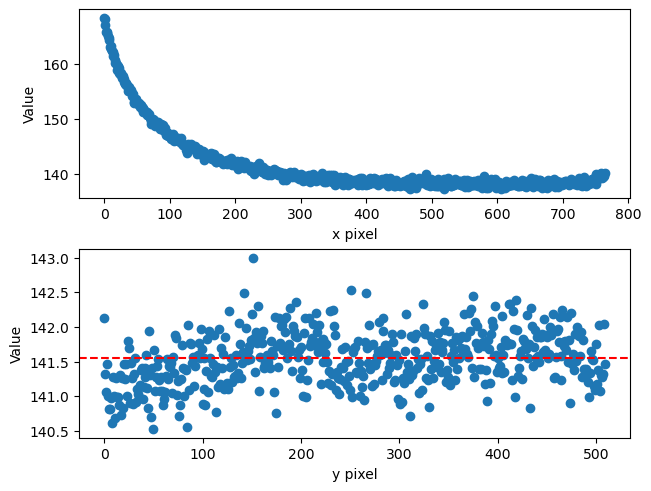

In [4]:
# Bias Plotter

# Read the bias file
path = 'shared/data/AS35/'
filename = "Calibration/Bias-S008-R002-C001-B2.fts"
ccd = CCDData.read(path+filename, unit=u.adu)

# Calculate the mean value averaging along the y and x axis
bias_x = np.mean(ccd.data, axis=0)
bias_y = np.mean(ccd.data, axis=1)

# Plot figures
fig,axs=plt.subplots(2, 1, layout='constrained')

axs[0].plot(bias_x, 'o')
axs[0].set_xlabel('x pixel')
axs[0].set_ylabel('Value')

mean_value_y = np.mean(bias_y)
print(mean_value_y)

axs[1].plot(bias_y, 'o')
axs[1].axhline(y=mean_value_y, color='r', linestyle='--', label=f'Mean: {mean_value_y:.2f}')
axs[1].set_xlabel('y pixel')
axs[1].set_ylabel('Value')

# Combine Bias Frames

The code below combines (averages) all the bias frames `Bias*.fts` producing a single output file in the created master folder (`master/master_bias.fits`), and computes the mean and standard deviation of the master bias values in a given region of the detector.

In [4]:
# Combine Bias Frames

path = 'shared/data/AS35/'
files = glob.glob(path + "Calibration/Bias*.fts")

# Create the master calibration directory if needed
if not os.path.exists("master"):
    os.makedirs("master")

# Read the bias files
bias_list = []
for bias in files:
    ccd = CCDData.read(bias, unit=u.adu)
    bias_list.append(ccd)

    # Combine the bias
    master_bias = ccdproc.combine(bias_list, method='average', dtype="float32")

mean = []
std = []

# Calculate the mean and the standard deviation in the area delimited by (x1,y1) (x2,y2)
# EDIT the values of x1, x2, y1, and y2
x1, x2, y1, y2 = 400, 750, 0, 500
meanj, median, stdj = sigma_clipped_stats(master_bias.data[y1:y2, x1:x2], sigma=3.0, maxiters=5)
mean.append(meanj)
std.append(stdj)

print ("mean = ", meanj)
print ("std = ", stdj)

# Save the master bias
master_bias.write("master/master_bias.fits", overwrite=True)
print ("Created master/master_bias.fits")


mean =  137.04539489746094
std =  2.7074835300445557
Created master/master_bias.fits


plot standard deviation vs number of frames

Fit: y = -0.00x^2 + -0.50x + 2.14
8.509140773810897
144.64492435729807


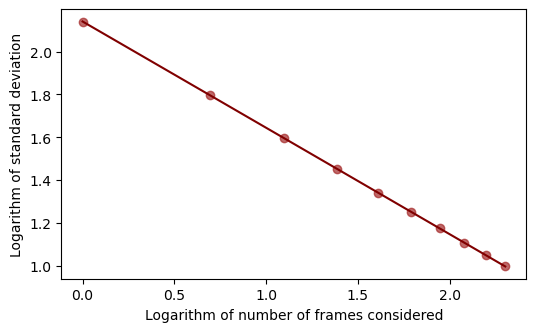

In [7]:
# Read the bias files
path = 'shared/data/AS35/'
files = glob.glob(path + "Calibration/Bias*.fts")


mean = []
std = []
bias_list = []
data_points = []
x1, x2, y1, y2 = 400, 750, 0, 500
i = 1

for bias in files:
    ccd = CCDData.read(bias, unit=u.adu)
    bias_list.append(ccd)

    # Combine the bias
    master_bias = ccdproc.combine(bias_list, method='average', dtype="float32")

    meanj, median, stdj = sigma_clipped_stats(master_bias.data[y1:y2, x1:x2], sigma=3.0, maxiters=5)
    mean.append(meanj)
    std.append(stdj)
    data_points.append(i)
    i += 1

log_data_x = np.log(data_points)
log_data_y = np.log(std)

# Let's try a quadratic regression
coeffs = np.polyfit(log_data_x, log_data_y, 2)
y_fit = coeffs[0] * log_data_x**2 + coeffs[1] * log_data_x + coeffs[2]

plt.plot(log_data_x, y_fit, color='maroon', label=f'Fit: y = {coeffs[0]:.2f}x^2 + {coeffs[1]:.2f}x + {coeffs[2]:.2f}')
print(f'Fit: y = {coeffs[0]:.2f}x^2 + {coeffs[1]:.2f}x + {coeffs[2]:.2f}')

# Plot the log-transformed data series against each other
plt.gcf().set_size_inches(6, 3.5)
plt.scatter(log_data_x, log_data_y, label='Log(Data Series)', color='brown', alpha=0.7)
plt.xlabel('Logarithm of number of frames considered')
plt.ylabel('Logarithm of standard deviation')

print(np.exp(coeffs[2]))
print(np.exp((coeffs[2] + 0.346)*2))

Given some true standard deviation $\sigma$, we expect the standard deviation of our sample $s$ to behave as:

$$ s = \frac{\sigma}{\sqrt{N}} $$

$$ \ln(s) = \ln(\sigma) - \frac{1}{2} \ln(N) $$

Given our y-intercept on this graph is $2.14$, we can simply take the exponent and find that $\sigma = 8.51$.

Our mean bias is something like $141.5$, so to get within $0.5\%$ accuracy we need a standard deviation which is around $0.7$ - the log of which is $-0.35$. The value of $\ln(N)$ to which this corresponds is $4.97$, so we would need $145$ frames in order to determine the mean within $0.5\%$ accuracy, which is quite a bit more than we have! Our estimate is already pretty good though, so I think we should probably be fine.



# Dark Frames  - plot(exp, std)

Proceed like for the bias, but this time using the dark frames `Dark*R00*.fts` and in groups of different exposure time as indicated by the numbers `R00*` to estimate the mean and standard deviation of each group. The exposure time can be extracted from the header as `t_exp = master_dark.header["EXPTIME"]`

Plot the mean number of counts as a function of the exposure time and do a log-log fit

136.2245418428809


Text(0, 0.5, 'value')

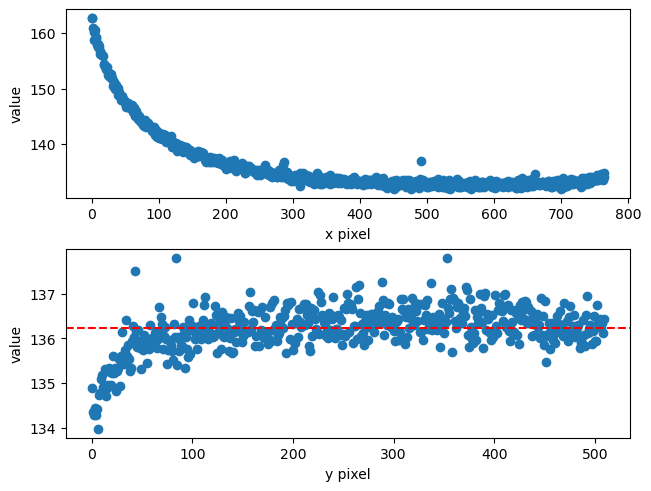

In [6]:
# Bias Plotter
# Read the bias file
path = 'shared/data/AS35/'
filename = "Calibration/Dark-S009-R001-C001-B2.fts"
ccd = CCDData.read(path+filename, unit=u.adu)

# Calculate the mean value averaging along the y and x axis
bias_x = np.mean(ccd.data, axis=0)
bias_y = np.mean(ccd.data, axis=1)

# Plot figures
fig,axs=plt.subplots(2, 1, layout='constrained')

axs[0].plot(bias_x, 'o')
axs[0].set_xlabel('x pixel')
axs[0].set_ylabel('value')

mean_value_y = np.mean(bias_y)
print(mean_value_y)

axs[1].plot(bias_y, 'o')
axs[1].axhline(y=mean_value_y, color='r', linestyle='--', label=f'Mean: {mean_value_y:.2f}')
axs[1].set_xlabel('y pixel')
axs[1].set_ylabel('value')

Fit: y = 0.0146x + 132.75


Text(0, 0.5, 'Mean counts')

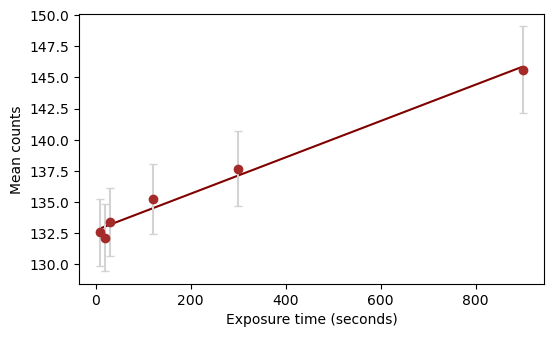

In [8]:
path = 'shared/data/AS35/'



mean = []
std = []
R = 1
exposures = [10, 20, 30, 120, 300, 900]
exposures = np.array(exposures)


x1, x2, y1, y2 = 400, 750, 100, 500


for R in range(1,7):
    
    files = glob.glob(f"{path}Calibration/Dark*R00{R}*.fts")
    bias_list = []

    for bias in files:
        ccd = CCDData.read(bias, unit=u.adu)
        bias_list.append(ccd)
    
        # Combine the bias
    master_bias = ccdproc.combine(bias_list, method='average', dtype="float32")
    
    meanj, median, stdj = sigma_clipped_stats(master_bias.data[y1:y2, x1:x2], sigma=3.0, maxiters=5)
    mean.append(meanj)
    std.append(stdj)

    R += 1



# Let's try a linear regression
slope, intercept = np.polyfit(exposures, mean, 1)
y_fit = slope * exposures + intercept


print(f'Fit: y = {slope:.4f}x + {intercept:.2f}')

# Plot the log-transformed data series against each other
plt.plot(exposures, y_fit, color='maroon')
plt.gcf().set_size_inches(6, 3.5)
plt.errorbar(exposures, mean, yerr=std, fmt='o', color='brown', ecolor='lightgray', capsize=3, label='Data with Errors')

plt.xlabel('Exposure time (seconds)')
plt.ylabel('Mean counts')



As anticipated, the data is broadly following the straight line relation between counts and exposure time, though not particularly well at the lower end. We can simply read off the value for $\alpha$ from our linear regression:

$$ \alpha = 0.015 $$

Our linear regression also suggests that the mean bias is something like $133$ counts, which is around $10\%$ lower than the value we had measured from the calibration frames. This is beacause we cover the telescope when taking dark frames, so background noise from this sky has been eliminated.

# Master Dark Frame

Combines all the dark frames for the longest exposure time, indicated by the file names `Dark*R006*C*-B2.fts`. Proceed like for the `master_bias` but after reading each file, subtract the `master_bias` from each dark frame using `ccdproc.subtract_bias`. Then save the master dark as `master/master_dark.fits`.

In [8]:
# Combine Bias Frames

path = 'shared/data/AS35/'
files = glob.glob(path + "Calibration/Dark*R006*C*-B2.fts")

# Create the master calibration directory if needed
if not os.path.exists("master"):
    os.makedirs("master")

# Read the bias files
bias_list = []
for bias in files:
    ccd = CCDData.read(bias, unit=u.adu)
    bias_list.append(ccdproc.subtract_bias(ccd, master_bias))

    # Combine the bias
    master_dark = ccdproc.combine(bias_list, method='average', dtype="float32")

mean = []
std = []

# Calculate the mean and the standard deviation in the area delimited by (x1,y1) (x2,y2)
# EDIT the values of x1, x2, y1, and y2
x1, x2, y1, y2 = 400, 750, 100, 500
meanj, median, stdj = sigma_clipped_stats(master_dark.data[y1:y2, x1:x2], sigma=3.0, maxiters=5)
mean.append(meanj)
std.append(stdj)

print ("mean = ", meanj)
print ("std = ", stdj)

# Save the master bias
master_dark.write("master/master_dark.fits", overwrite=True)
print ("Created master/master_dark.fits")


mean =  -8.224875003293164e-09
std =  4.401026671985164e-06
Created master/master_dark.fits


Note that this is slightly sloppy, as the master bias we recorded from the original calibration frames is actually not the same as the mean bias for the dark frames. To correct this, we could find the mean difference of the max exposure dark frames from the y-intercept we calculated earlier and then subtract the difference between that y-intercept and master bias. That said, our current approach is pretty much going to yield the same results.

# Combine Flat Field Frames
The code below combines the flat field frames for the given filter.

In [4]:
# Combine Flat Field Frames

path = 'shared/data/AS35/'
filter_name = 'B'

files = glob.glob(path + f"Calibration/Auto*-{filter_name}-*.fts")

# Read the master bias
master_bias = CCDData.read("master/master_bias.fits")

# Read the master dark
master_dark = CCDData.read("master/master_dark.fits")

# Read the flat files
flat_list = []
for flat in files:
    ccd = CCDData.read(flat, unit=u.adu)

    # Subtract the master bias
    ccd = ccdproc.subtract_bias(ccd, master_bias)
    # and subtract the dark current scaled by the exposure time
    ccd = ccdproc.subtract_dark(ccd, master_dark, dark_exposure=master_dark.header["EXPTIME"]*u.s, data_exposure=ccd.header["EXPTIME"]*u.s, scale=True)
    # Normalize the flat field
    ccd.data = ccd.data/np.median(ccd.data)	
    flat_list.append(ccd)
        
# Combine the flats
master_flat = ccdproc.combine(flat_list, method='median', dtype="float32")

# Save the master flat
filter_name = ccd.header["FILTER"].strip()
master_flat.write("master/master_flat_" + filter_name + ".fits", overwrite=True)
print ("Created master_flat_" + filter_name + ".fits")

Created master_flat_B.fits


# Reduction of Science Frames
The following script reduces the science frames, using the calibration frames from the master folder and saves the reduced frames in the `NGC0663_frames` directory.

In [ ]:
# Reduction of science frames

path = 'shared/data/AS35/'
# EDIT the name of the cluster
target = "NGC0663"

# Read the master bias
master_bias = CCDData.read("master/master_bias.fits")

# Read the master dark
master_dark = CCDData.read("master/master_dark.fits")

# Create the output directory if needed
if not os.path.exists(target + "_frames"):
    os.makedirs(target + "_frames")

# Find raw science frames
sci_files = glob.glob(path + target + "/" + target + "*")
# and reduce
for i, sci in enumerate(sci_files):
    # Read the science frame
    ccd = CCDData.read(sci, unit=u.adu)

    # Mask saturated pixels
    mask_saturated = (ccd.data > 50000)
    ccd.data = np.array(ccd.data, dtype=np.float32)
    ccd.data[mask_saturated] = np.nan

    # Load the appropriate flat field for this frame
    filter_name = ccd.header["FILTER"].strip()

    master_flat =  CCDData.read("master/master_flat_" + filter_name + ".fits")

    # Subtract bias
    ccd = ccdproc.subtract_bias(ccd, master_bias)

    # Subtract dark current
    ccd = ccdproc.subtract_dark(ccd, master_dark, dark_exposure=master_dark.header["EXPTIME"]*u.s, data_exposure=ccd.header["EXPTIME"]*u.s, scale=True)

    # Divide by flat
    ccd = ccdproc.flat_correct(ccd, master_flat, min_value=0.5)

    # Subtract global sky background
    mean, background, std = sigma_clipped_stats(ccd.data, sigma=3.0, maxiters=5)
    ccd.data = ccd.data - background

    # Divide by the exposure time
    ccd.data = ccd.data/ccd.header["EXPTIME"]
    ccd.uncertainty = None
    ccd.unit=u.adu/u.s
    ccd_test = fits.open(sci)
    ccd.header = ccd_test[0].header
    
    # Add keywords to the header
    ccd.header['SKY'] = background
    ccd.header['RAWFILE'] = sci

    # Save the calibrated frame
    ccd.write(target + "_frames/" + target + "_" + filter_name + "_" + '{:04d}'.format(i)  + ".fits" , overwrite=True)
    print ("Created " + target + "_frames/" + target + "_" + filter_name + "_" + '{:04d}'.format(i)  + ".fits")

Note that the script is essentially implementing this formula:

$$ \mathrm{Reduced} = \frac{\mathrm{Raw} - B - D}{F}$$

# Combine Science Frames
The following script combines the science frames, while shifting all to a common reference in sky coodinates

In [ ]:
# Combine Science Frames

# EDIT the name of the cluster and the filters you want to image
target = "NGC0663"
filter_name = "V"

# Create the output directory if needed
if not os.path.exists(target + "_combined"):
    os.makedirs(target + "_combined")

# Find science frames for this filter
sci_files = glob.glob(target + "_frames/" + target + "_" + filter_name + "_*.fits")

sci_list = []
ra = []
dec = []
for file in sci_files:
    # Read the file
    ccd = CCDData.read(file)
    ccd_test = fits.open(file)
    ccd.header = ccd_test[0].header
    # Store the coordinates of the frame corners
    w = wcs.WCS(ccd.header)
    
    ra1, dec1 = w.wcs_pix2world(1, 1, 1)
    ra2, dec2 = w.wcs_pix2world(ccd.header["NAXIS1"], ccd.header["NAXIS2"], 1)
    
    ra.append(ra1)
    ra.append(ra2)
    dec.append(dec1)
    dec.append(dec2)

    sci_list.append(ccd)

# Determine the reference image for the combination
# convert lists to numpy arrays
ra = np.array(ra)
dec = np.array(dec)
# Calculate average RA and Dec of the frames
mean_ra = 0.5*(max(ra) + min(ra))
mean_dec = 0.5*(max(dec) + min(dec))

# Create reference header
ref_header = sci_list[0].header.copy()
dist_ra = (((min(ra) - max(ra))*np.cos(np.radians(mean_dec)))**2 + (mean_dec - mean_dec)**2)**0.5
dist_dec = (((mean_ra - mean_ra)*np.cos(np.radians(mean_dec)))**2 + (max(dec) - min(dec))**2)**0.5

pix_size = abs(ref_header["CD1_1"])

npix_ra = int(dist_ra/pix_size)
npix_dec = int(dist_dec/pix_size)

ref_header["CRVAL1"] = mean_ra
ref_header["CRPIX1"] = npix_ra*0.5
ref_header["CRVAL2"] = mean_dec
ref_header["CRPIX2"] = npix_dec*0.5

ref_header["NAXIS1"] = npix_ra
ref_header["NAXIS2"] = npix_dec

#Reproject the frames
exposure_map = np.zeros((npix_dec, npix_ra))
for i, ccd in enumerate(sci_list):
    print ("projecting " + str(i+1) + "/" + str(len(sci_list)))
    ccd.data, _ = reproject_interp((ccd.data, ccd.header), ref_header)
    
    exptime, _ = reproject_interp((np.zeros_like(ccd.data) + ccd.header["EXPTIME"], ccd.header), ref_header)
    mask_exptime = (~np.isfinite(exptime)) + ~(np.isfinite(ccd.data))
    exptime[mask_exptime] = 0.
    exposure_map = exposure_map + exptime
    
    # and mask nan values
    ccd.mask = ~np.isfinite(ccd.data)

# Combine all the frames
combined_image = ccdproc.combine(sci_list, method='median', dtype="float32")
# Save the combined frame
hdu = combined_image.to_hdu()
hdu[0].header["CRVAL1"] = mean_ra
hdu[0].header["CRPIX1"] = npix_ra*0.5
hdu[0].header["CRVAL2"] = mean_dec
hdu[0].header["CRPIX2"] = npix_dec*0.5

# Mask pixel with low integration times
exposure_map = medfilt(exposure_map, (15, 15)) # but keep bright stars
mask_lowexposure = (exposure_map < np.median(exposure_map)*0.5)

hdu[0].data[mask_lowexposure] = np.nan

hdu.writeto(target + "_combined/" + target + "_" + filter_name + "_combined.fits", overwrite=True)

print ("Created " + target + "_combined/" + target + "_" + filter_name + "_combined.fits")

# Star Detection
The following code detects stars in the image for a given target and filter and save their coordinates.

Found 624 sources


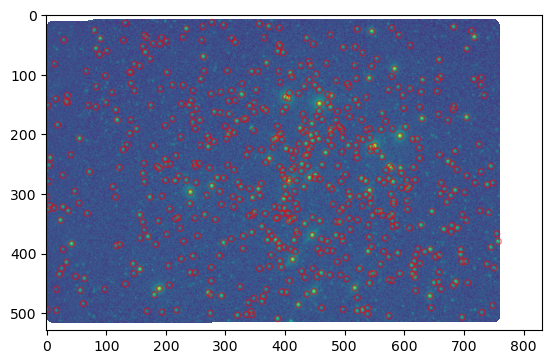

Sources plotted in NGC0663_filter_V.png
Coordinates saved in stars_NGC0663_V.txt


In [5]:
# Star Detection

def find_stars(target, filter_name):
    filename = target + "_combined/" + target + "_" + filter_name + "_combined.fits"
    
    # Read the image
    hdulist = fits.open(filename)
    data = hdulist[0].data
    header = hdulist[0].header
    hdulist.close()
    
    # Compute the noise level
    mean, median, std = sigma_clipped_stats(data, sigma=3.0, maxiters=5)
    
    # Find stars above 10sigma
    daofind = DAOStarFinder(fwhm=3.0, threshold=10*std)
    sources = daofind(data - median)

    print ("Found " + str(len(sources)) + " sources")
    
    xpix = sources['xcentroid']
    ypix = sources['ycentroid']
    
    # Plot the stars in the image
    pixpos = list(zip(xpix,ypix))
    apertures = CircularAperture(pixpos, r=5)
    stretch = np.arcsinh((data - median)/std)
    plt.imshow(stretch)
    apertures.plot(color="red", alpha=0.5)
    plt.savefig(target + "_filter_" + filter_name + ".png", dpi=250)
    plt.show()
    print ("Sources plotted in " + target + "_filter_" + filter_name + ".png")
    
    # Convert from pixel to sky coordinates
    w = wcs.WCS(header)

    return w.all_pix2world(np.array([xpix, ypix]).T, 0)
    

# EDIT the name of the cluster and the filter name
target = "NGC0663"
ref_filter = "V"
stars = find_stars(target, ref_filter)

# Save the positions of the stars in a text file
np.savetxt("stars_" + target + "_" + ref_filter + ".txt", stars)
print ("Coordinates saved in stars_" + target + "_" + ref_filter + ".txt")

The dithering 'smears out' bad pixels so that their effect is reduced and a pixel does not become saturated if it is a single faulty pixel but only if it is an actual star (which will span many pixels).

Using a lot of exposures is useful as it can give us a larger dynamic range - the lower exposures can be used to fill in darker regions and prevent the brighter ones from saturating, while the higher exposures can increase the signal-to-noise ration and distinguish the background more clearly from the stars.

# Aperture Photometry
The code below performs aperture photometry, by summing the signals from the dataimage for each of the specified star coordinates.

| Image X | Image Y | FWHM 1 | FWHM 2 | Avg FWHM | Arcseconds |
|---------|---------|--------|--------|----------|----------------|
| 457     | 146     | 2.38   | 2.42   | 2.40     | 3.60           |
| 240     | 295     | 2.35   | 2.33   | 2.34     | 3.51           |
| 262     | 68      | 2.50   | 2.57   | 2.535    | 3.80           |
| 412     | 408     | 2.38   | 2.78   | 2.58     | 3.87           |
| 354     | 290     | 2.40   | 2.51   | 2.455    | 3.68           |

In [ ]:
import matplotlib.pyplot as plt

# Define coordinates for a skinny isosceles triangle
x = [0, 4, 4]  # X-coordinates
y = [2, 2.4, 1.6]  # Y-coordinates

# Plot the triangle
fig, ax = plt.subplots(figsize=(8, 8))
ax.fill(x, y, 'navy', edgecolor='black', linewidth=2)  # Fill the triangle with color
ax.plot(x, y, 'k-', lw=2)  # Draw the triangle borders

# Add labels
ax.text(0, 2.4, r'$\theta$', fontsize=20, ha='center', va='center', color='black')  # Label for theta
ax.text(2, 1.4, '2100 pc', fontsize=20, ha='center', va='center', color='black')  # Label for pc
ax.text(4, 2.7, r'1.4 * 10^6 km', fontsize=20, ha='center', va='center', color='black')  # Label for km



# Set limits and appearance
ax.set_xlim(-1, 5)
ax.set_ylim(-1, 4)
ax.set_aspect('equal')
ax.axis('off')  # Hide axes
plt.show()

Using the perfectly valid (since this triangle is so skinny) small angle approximation, we will find that for a sun-like star we will have an angular width of:

$$ \theta = \frac{1.6 \times 10^6 \; \mathrm{km}}{2100 \; \mathrm{pc}} = 2.47 \times 10^{-11} \; \mathrm{rad} =  4.46 \times 10^{-6} \; \mathrm{arcseconds}$$

This many order of magnitude smaller than the objects we are investigating!

| Star ID# | m_B (mag) | m_V (mag) | RA         | Dec         | Counts B | Counts V | 
|----------|-----------|-----------|------------|-------------|----------|----------|
| 1477     | 10.347    | 9.590     | 01:47:08.90 | +61:11:54.6 |   4572       |    11178      |
| 1601     | 9.798     | 9.002     | 01:45:56.11 | +61:14:05.2 |     7514     |      19784    |
| 2615     | 9.139     | 8.537     | 01:46:23.80 | +61:15:29.5 |     13368     |     31272     |


In [ ]:
# Define the data
data = {
    "Star ID#": [1477, 1601, 2615],
    "m_B (mag)": [10.347, 9.798, 9.139],
    "m_V (mag)": [9.590, 9.002, 8.537],
    "RA": ["01:47:08.90", "01:45:56.11", "01:46:23.80"],
    "Dec": ["+61:11:54.6", "+61:14:05.2", "+61:15:29.5"],
    "Counts B": [4572, 7514, 13368],
    "Counts V": [11178, 19784, 31272]
}

# Create the DataFrame
df = pd.DataFrame(data)

df['Zeropoint B'] = df['m_B (mag)'] + 2.5 * np.log10(df['Counts B'])
df['Zeropoint V'] = df['m_V (mag)'] + 2.5 * np.log10(df['Counts V'])


# Display the DataFrame
df

The zeropoints are relatively consistent with each other, though the spread and low number of samples will give us a reasonable uncertainty.

$$ \mathrm{Zeropoint}  \;  \mathrm{(B)} = 19.48 \pm 0.02 $$
$$ \mathrm{Zeropoint} \;  \mathrm{(V)} = 19.74 \pm 0.03 $$

If the magnitude of the star is equal to the zeropoint, we will find that $\log_{10}(\mathrm{Counts} \; \mathrm{per} \; \mathrm{second}) = 0$ implying that we would find $1$ count per second.

In [ ]:
# Aperture Photometry

# EDIT the name of the cluster, the file the positions of the stars, the zeropoints and the aperture radius
target = "NGC0663"
stars_file = "stars_NGC0663_B.txt"
zeropoint_b = 19.48
zeropoint_v = 19.74
aperture_radius = 14 / 3

def do_photometry(target, filter_name, stars):
    filename = target + "_combined/" + target + "_" + filter_name + "_combined.fits"
    
    # Read the image
    hdulist = fits.open(filename)
    data = hdulist[0].data
    header = hdulist[0].header
    hdulist.close()
    
    # Convert from sky coordinates to pixel
    w = wcs.WCS(header)
    xpix,ypix = w.all_world2pix(stars, 0).T
    pixel_coordinates = list(zip(xpix,ypix))

    # Generate the annulus aperture for the local background
    annulus_apertures = CircularAnnulus(pixel_coordinates, r_in=6., r_out=12.)
    annulus_mask = annulus_apertures.to_mask()
    
    # and calculate the background level per pixel
    background_median = np.zeros(len(annulus_mask))
    for i, mask in enumerate(annulus_mask):
        data_cutout_aper = mask.cutout(data)
        background_median[i] = np.nanmedian(data_cutout_aper[data_cutout_aper != 0])

    # Generate the circular apertures
    apertures = CircularAperture(pixel_coordinates, r=aperture_radius)
    # and do the photometry
    fluxes = aperture_photometry(data, apertures)
    
    # Ignore the fluxes of stars too close the image borders
    mask_size = 15
    mask = (xpix < mask_size) | (xpix > data.shape[1] - mask_size) | (ypix < mask_size) | (ypix > data.shape[0] - mask_size)
    fluxes["aperture_sum"][mask] = np.nan
    
    # Return the background subtracted fluxes
    return fluxes["aperture_sum"] - background_median*apertures.area


# Load the location of the stars
stars = np.loadtxt(stars_file)

# Measure the fluxes in counts/s in the B and V images
flux_b = do_photometry(target, "B", stars)
flux_v = do_photometry(target, "V", stars)

# Convert from fluxes to magnitudes using the provided zeropoint
mag_b = zeropoint_b -2.5*np.log10(flux_b)
mag_v = zeropoint_v -2.5*np.log10(flux_v)

# Save the positions and fluxes
mask = np.isfinite(mag_b) & np.isfinite(mag_v)
data = np.array([stars[mask, 0], stars[mask, 1], mag_b[mask], mag_v[mask]]).T
np.savetxt("mag_" + target + ".txt", data, fmt=['%12.7f','%12.7f','%7.3f','%7.3f'], header='# RA Dec magb magv')
print ("Magnitudes saved in mag_" + target + ".txt")

# Isochrone Fitter
The code below produces an interactive colour-magnitude plot for a given cluster, along with a model isochrone which can be interactively changed using the three sliders.

In [11]:
# Isochrone Fitter

path = 'shared/data/AS35/'
modelfile = "PadovaCMD.dat"
target = "NGC1039"

# read the data magnitude values
magb, magv = np.loadtxt(f"FILTERED_mag_{target}.txt", usecols=[2, 3]).T
color = magb - magv

# read the B and V model magnitude values
age_model, b_model, v_model = np.loadtxt(path + modelfile, usecols=[1, 9, 10]).T
color_model = b_model - v_model
    
def update(lg_age=7.3, dist_mod=12.1,  extinction=0.7):
    w = age_model == round(lg_age, 1)
    x = color_model[w] + extinction
    y = v_model[w] + dist_mod + 3*extinction
    plt.scatter(color, magv, c=color.clip(*np.percentile(color, [5, 95])), label='data',
                cmap='Spectral_r', marker='*', edgecolors='k', linewidths=0.1, s=10*(19 - magv))
    plt.plot(x, y, label='model')
    textstr = f'lg(Age): {lg_age:.1f}\nDist Mod: {dist_mod:.1f}\nExtinction: {extinction:.1f}'
    plt.title('NGC1039')
    plt.xlim(-1, 3)
    plt.ylim(18, 7)
    plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.xlabel("B - V colour")
    plt.ylabel("V magnitude")
    plt.show()

interact(update, lg_age=(6.6, 9.9, 0.1), dist_mod=(8, 15, 0.1), extinction=(0, 2, 0.1));


interactive(children=(FloatSlider(value=7.3, description='lg_age', max=9.9, min=6.6), FloatSlider(value=12.1, …

The colour of a star is reflective of its temperature, while its magnitude refers to the luminosity or brightness of a star. In this manner a CMD allows us to form a relationship between these two different parameters. If we plotted a magnitude-magnitude graph, the overall trend would simply be a linear relationship as the magnitudes of each filter are highly correlated with only slight deviations.

If we vary the distance modulus, the model simply translates up (increased distance) or down (decreased distance) linearly. This makes sense as lower magnitudes (higher up on the graph) are brighter and, since magnitudes are a logarithm of the observed luminosity, a multiplicative scale factor will become a straightfoward linear shift.

At the start of the star's lifetime, most of the stars are still burning their initial hydrogen, so the isochrone sticks quite closely to the main sequence of the cluster. In the medium regime for age of the cluster, the most massive stars - which are also the brightest - have finished burning up the original supply of hydrogen and will begin to exit the main sequence, moving towards the cooler right-hand-side of the graph. The very oldest clusters will have stars that have entirely moved off of the main sequence and drifted towards the cooler side of the diagram, as they begin burning hydrogen. The most massive stars have already died by this point and become black dwarves, neutron stars, or black holes, so only the high magnitude is present.

Extinction measures how much of the light from the cluster is scattered and absorbed by interstellar dust grains. Shorter wavelengths (blue light) are scattered more than longer wavelengths (red), so when we increase the extinction coefficient the isochrone model will move towards the right - indicating a redder observation. Also, the entire isochrone will move downwards, simply indicating that the light received is dimmer due to increased absorption by the interstellar dust grains.

Best fit parameters: \
lg_age ~7.40 \
dist_mod ~12.00 \
extinction ~0.70

We can be pretty confident on the age, as the isochrones begin to divert significantly if we adjust the age even a small amount from this timescale. We can be similarly confident for the exctinction, as changing it by even a small amount will drag the isochrone quite far away from our main sequence for NGC0663.

However, the distance modulus is a lot trickier, as the isochrone model is quite a bit taller (in magnitude) than the bulk of our main sequence stars.

## Finding the distance of the cluster

We have the relations:

$$ \mathrm{Mag} = - 2.5 \times \log_{10}(\mathrm{Flux}) $$

$$ \mathrm{Abs} \; \mathrm{Mag} = \mathrm{Mag} - \mathrm{Distance} \; \mathrm{Modulus} $$

Re-arranging this:

$$ \mathrm{Distance} \; \mathrm{Modulus} = 2.5 \left[ \log_{10} \left( \frac{P}{4 \pi \times (10 \mathrm{pc})^2} \right) - \log_{10} \left( \frac{P}{4 \pi \times D^2} \right) \right]$$

$$ = 2.5 \left[ \log_{10} \left( P \right) - \log_{10} \left({4 \pi (10 \mathrm{pc})^2} \right) - \log_{10} \left( P \right) + \log_{10} \left( 4 \pi D^2 \right) \right]$$

$$ = 5 \left[\log_{10} \left({10 \mathrm{pc}} \right) - \log_{10} \left( D \right) \right] $$

$$ D = 10 \mathrm{pc} \times 10^{\frac{1}{5} \mathrm{Distance} \; \mathrm{Modulus}} = 2500 \; \mathrm{pc}$$

## Finding the size of the cluster

The cluster spans 500 pixels on the CCD detector, with each pixel equivalent to 1.5 arcseconds across the sky. In total the cluster therefore spans 750 arcseconds.

Using the small angle approximation we may write:

 $$ R = \frac{750}{3600 \times 180 / 2 \pi} \times 2500 =  9.1 \; \mathrm{pc}$$

## Finding the density of the cluster

Assuming the cluster is roughly spherical we can find an approximation for the volume, allowing us to find the density of population - as we have identified 624 stars.

$$ \rho_{\mathrm{stars}} = \frac{624}{4/3 \times \pi \times 9.1 ^3} = 0.20 \; \mathrm{stars/pc^3}$$

Around the sun the density of stars is ~0.14 $\mathrm{stars/pc^3}$, so this cluster is slightly more populated, but very similar to our own. This makes sense as it is a young and visible stellar cluster.

# Mini-Project

In [ ]:
# Isochrone Fitter

path = 'shared/data/AS35/'
modelfile = "PadovaCMD.dat"
target = "NGC0663"

# read the data magnitude values
magb, magv = np.loadtxt('NGC0663', usecols=[2, 3]).T
color = magb - magv

# read the B and V model magnitude values
age_model, b_model, v_model = np.loadtxt(path + modelfile, usecols=[1, 9, 10]).T
color_model = b_model - v_model
    
def update(lg_age=7.3, dist_mod=12.1,  extinction=0.7):
    w = age_model == round(lg_age, 1)
    x = color_model[w] + extinction
    y = v_model[w] + dist_mod + 3*extinction
    plt.scatter(color, magv, c=color.clip(*np.percentile(color, [5, 95])), label='data',
                cmap='Spectral_r', marker='*', edgecolors='k', linewidths=0.1, s=10*(19 - magv))
    plt.plot(x, y, label='model')
    plt.legend()
    plt.xlim(-1, 3)
    plt.ylim(18, 7)
    plt.xlabel("B - V colour")
    plt.ylabel("V magnitude")
    plt.show()

interact(update, lg_age=(6.6, 9.9, 0.1), dist_mod=(8, 15, 0.1), extinction=(0, 2, 0.1));